In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Sentence embeddings and textual similarity

In this notebook we try to replicate the experimental results on textual similarity tasks from **A Simple but Tough-to-Beat Baseline for Sentence Embeddings** (Arora *et al*. 2017, https://openreview.net/pdf?id=SyK00v5xx)

## Semantic Textual Similarity (STS) data

The [SemEval](http://alt.qcri.org/semeval2016/) data are obtained from the `datasets-sts` repo: https://github.com/brmson/dataset-sts

`pysts` (included in this repo) can be used to load STS tasks data.

In [2]:
import sys
sys.path.append('./dataset-sts/')

In [3]:
import pysts
from pysts.loader import load_sts

For example, the headlines dataset of SemEval 2015:

In [4]:
s0, s1, labels = load_sts("dataset-sts/data/sts/semeval-sts/2015/headlines.test.tsv")

This gives two lists of lists of the sentences (`s0` and `s1`), and the corresponding labels:

In [5]:
s0[0]

['The',
 'foundations',
 'of',
 'South',
 'Africa',
 'are',
 'built',
 'on',
 'Nelson',
 'Mandela',
 "'s",
 'memory']

In [6]:
s1[0]

['Australian',
 'politicians',
 'lament',
 'over',
 'Nelson',
 'Mandela',
 "'s",
 'death']

In [7]:
labels[0]

1.3

By default, it excluded those pair of sentences that had not a label (can also use `skip_unlabeled=False`):

In [8]:
len(labels)

750

In [9]:
s0, s1, labels = load_sts("dataset-sts/data/sts/semeval-sts/2015/headlines.test.tsv", skip_unlabeled=False)

In [10]:
len(labels)

1500

In [11]:
s0, s1, labels = load_sts("dataset-sts/data/sts/semeval-sts/2015/headlines.test.tsv", skip_unlabeled=True)

## GloVe pre-trained word vectors 

GloVe - Global Vectors for Word Representation (https://nlp.stanford.edu/projects/glove/). Pre-trained word vectors have been downloaded (we use the 300-dimensional vectors trained on the 840 billion token Common Crawl corpus: http://nlp.stanford.edu/data/glove.840B.300d.zip), and converted to a dictionary for further usage:
    
    import pandas as pd
    import zipfile
    
    z = zipfile.ZipFile("./glove.840B.300d.zip")
    glove = pd.read_csv(z.open('glove.840B.300d.txt'), sep=" ", quoting=3, header=None, index_col=0)
    glove2 = {key: val.values for key, val in glove.T.items()}
    
    import pickle
    with open('glove.840B.300d.pkl', 'wb') as output:
        pickle.dump(glove2, output)

In [12]:
import pickle

In [13]:
with open('glove.840B.300d.pkl', 'rb') as pkl:
    glove = pickle.load(pkl)

For example, the 300 D array for 'python':

In [14]:
glove['python'].shape

(300,)

In [15]:
glove['python'][:10]

array([ 0.035414, -0.4573  ,  0.42617 ,  0.23448 ,  0.18446 ,  0.78676 ,
        0.15513 , -0.41701 ,  0.36996 , -0.25015 ])

For some of the methods below, we also need the word frequencies estimated from the corpus. As we currently don't have this available for the GloVe pretrained vectors / Common Crawl corpus, we use the `wordfreq` package (https://github.com/LuminosoInsight/wordfreq/): 

In [16]:
import wordfreq

In [17]:
wordfreq.word_frequency('python', 'en', wordlist='large')

3.981071705534969e-06

In [18]:
wordfreq.word_frequency('and', 'en', wordlist='large')

0.022908676527677734

## Predict similarity between sentences (STS tasks) based on GloVe

To predict the similarity between two sentences, the word embeddings (using the GloVe word vectors) are combined into a sentence embedding. 

Similarity is calculate as the cosine similarity of the two sentence embeddings, and the performance is evaluated as the Pearson's coefficient between the predicted scores and the labels:

In [19]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [20]:
from scipy.stats import pearsonr

### avg-GloVe: unweighted average of GloVe vectors

A simple method is to take the unweighted average of the different word vectors:

In [21]:
def sentence_vector_avg(sentence):
    """Calculate the sentence vector as the mean of the word vectors"""
    
    word_vecs = []
    for token in sentence:
        token = token.lower()
        try:
            word_vecs.append(np.array(glove[token]))
        except KeyError:
            pass

    return np.array(word_vecs).mean(axis=0)

def embed_avg(sentences):
    """Calculate sentence embeddings for set of sentences
    based on the average of the word vectors
    """
    
    values = []
    for s in sentences:
        mean = sentence_vector_avg(s)
        values.append(mean)
        
    return np.array(values)

Predict similarity between two sentences:

In [22]:
v0 = sentence_vector_avg(s0[0])

In [23]:
v1 = sentence_vector_avg(s1[0])

In [24]:
cosine_similarity(v0, v1)

0.73405983546708098

Predict similarity for the full set of sentences:

In [25]:
Vs0 = embed_avg(s0)
Vs1 = embed_avg(s1)
predicted = np.array([cosine_similarity(vs0, vs1) for vs0, vs1 in zip(Vs0, Vs1)])

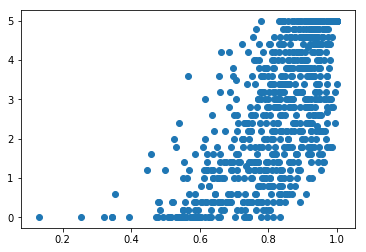

In [26]:
plt.scatter(predicted, labels)

The evaluation criterion is the Pearson's coefficient between the predicted scores and the labels:

In [27]:
pearsonr(predicted, labels)[0]

0.66095534976480941

#### Systematically on all STS tasks

In [28]:
def evaluate_tasks(files, embed_func):

    tests = []
    scores = []

    for f in files:
        s0, s1, labels = load_sts(f)
        Vs0 = embed_func(s0)
        Vs1 = embed_func(s1)
        predicted = np.array([cosine_similarity(vs0, vs1) for vs0, vs1 in zip(Vs0, Vs1)])
        rp = pearsonr(predicted, labels)[0]

        scores.append(rp)
        name = f.split('/')[-1].split('.')
        tests.append((name[0], name[1]))
    
    return pd.Series(scores, index=pd.MultiIndex.from_tuples(tests))

In [29]:
import glob

In [30]:
files = glob.glob("dataset-sts/data/sts/semeval-sts/all/*.test.tsv")
files

['dataset-sts/data/sts/semeval-sts/all/2012.MSRpar.test.tsv',
 'dataset-sts/data/sts/semeval-sts/all/2012.OnWN.test.tsv',
 'dataset-sts/data/sts/semeval-sts/all/2012.SMTeuroparl.test.tsv',
 'dataset-sts/data/sts/semeval-sts/all/2012.SMTnews.test.tsv',
 'dataset-sts/data/sts/semeval-sts/all/2013.FNWN.test.tsv',
 'dataset-sts/data/sts/semeval-sts/all/2013.OnWN.test.tsv',
 'dataset-sts/data/sts/semeval-sts/all/2013.headlines.test.tsv',
 'dataset-sts/data/sts/semeval-sts/all/2014.OnWN.test.tsv',
 'dataset-sts/data/sts/semeval-sts/all/2014.deft-forum.test.tsv',
 'dataset-sts/data/sts/semeval-sts/all/2014.deft-news.test.tsv',
 'dataset-sts/data/sts/semeval-sts/all/2014.headlines.test.tsv',
 'dataset-sts/data/sts/semeval-sts/all/2014.images.test.tsv',
 'dataset-sts/data/sts/semeval-sts/all/2014.tweet-news.test.tsv',
 'dataset-sts/data/sts/semeval-sts/all/2015.answers-forums.test.tsv',
 'dataset-sts/data/sts/semeval-sts/all/2015.answers-students.test.tsv',
 'dataset-sts/data/sts/semeval-sts/al

In [31]:
files.remove('dataset-sts/data/sts/semeval-sts/all/2015.test.tsv')

In [32]:
res_avg = evaluate_tasks(files, embed_avg)

In [33]:
res = res_avg.to_frame(name='avg-GloVe') * 100

In [34]:
res.round(1)

avg-GloVe
2012 MSRpar                  43.4
     OnWN                    56.7
     SMTeuroparl             41.2
     SMTnews                 46.7
2013 FNWN                    38.0
     OnWN                    47.1
     headlines               63.1
2014 OnWN                    57.6
     deft-forum              27.8
     deft-news               65.0
     headlines               59.3
     images                  62.4
     tweet-news              54.7
2015 answers-forums          34.4
     answers-students        63.1
     belief                  44.1
     headlines               66.1
     images                  69.1
2016 answer-answer           38.3
     headlines               61.1
     plagiarism              52.6
     postediting             54.4
     question-question       48.5

In [35]:
res.mean(axis=0, level=0).round(1)

,avg-GloVe
2012,47.0
2013,49.4
2014,54.4
2015,55.4
2016,51.0


### GloVe+W: weighted average of GloVe vectors

In the Arora *et al.* (2017) paper, a weighted average of the word vectors (smooth inverse frequency weighting) is used based on word frequencies estimated from the commoncrawl dataset. Here, we use the `wordfreq` package (https://github.com/LuminosoInsight/wordfreq/) as alternative.

In [36]:
import wordfreq

def sentence_vector_avg_W(sentence, a=1e-3):
    """Calculate the sentence vector as the mean of the word vectors"""
    
    word_vecs = []
    for token in sentence:
        token = token.lower()
        try:
            vw = np.array(glove[token])
            freq = wordfreq.word_frequency(token, 'en', wordlist='large')
            vw *= a / (a + freq)
            word_vecs.append(vw)
        except KeyError:
            pass

    return np.array(word_vecs).mean(axis=0)

def embed_avg_W(sentences):
    """Calculate sentence embeddings for set of sentences
    based on the average of the word vectors
    """
    
    values = []
    for s in sentences:
        mean = sentence_vector_avg_W(s)
        values.append(mean)
        
    return np.array(values)

In [37]:
res_avg_W = evaluate_tasks(files, embed_avg_W)

In [38]:
res = pd.concat([res_avg, res_avg_W], keys=['avg-GloVe', 'GloVe+W'], axis=1) * 100

In [39]:
res.round(1)

avg-GloVe  GloVe+W
2012 MSRpar                  43.4     40.5
     OnWN                    56.7     61.0
     SMTeuroparl             41.2     46.2
     SMTnews                 46.7     50.9
2013 FNWN                    38.0     39.5
     OnWN                    47.1     65.5
     headlines               63.1     66.2
2014 OnWN                    57.6     70.8
     deft-forum              27.8     31.9
     deft-news               65.0     69.8
     headlines               59.3     62.0
     images                  62.4     76.4
     tweet-news              54.7     58.6
2015 answers-forums          34.4     46.7
     answers-students        63.1     66.0
     belief                  44.1     56.8
     headlines               66.1     69.5
     images                  69.1     76.7
2016 answer-answer           38.3     49.0
     headlines               61.1     65.6
     plagiarism              52.6     68.8
     postediting             54.4     66.2
     question-question       48.5     64.0

In [40]:
res.mean(axis=0, level=0).round(1)

,avg-GloVe,GloVe+W
2012,47.0,49.7
2013,49.4,57.1
2014,54.4,61.6
2015,55.4,63.1
2016,51.0,62.7


The weighting scheme considerably improves the similarity scores.

### Using the GloVe+WR method

The weighted average from above, but now combined with a removal of the common components, from Arora *et al.* (2017) (https://openreview.net/pdf?id=SyK00v5xx)

The algorithm for sentence embedding (Algorithm 1, page 6, Arora et al. 2017):

> **Input** Word embeddings $\{v_w : w \in \mathcal{V}\}$, a set of sentences $\mathcal{S}$, parameter $a$ and estimated probabilities $\{p(w) : w \in \mathcal{V}\}$.  
> **Output**: Sentence embeddings $\{v_s : s \in \mathcal{S}\}$
>
> 1: **for all** sentence $s$ in $\mathcal{S}$ **do**  
> 2: $ \phantom{...} v_s \gets \frac{1}{|s|} \sum_{w \in s}{\frac{a}{a + p(w)} v_w}$  
> 3: **end for**  
> 4: Compute the first principal component $u$ of $\{v_s : s \in \mathcal{S}\}$  
> 5: **for all** sentence $s$ in $\mathcal{S}$ **do**  
> 6: $ \phantom{...} v_s \gets v_s - u u^T v_s$  
> 7: **end for**  

The weighted average to obtain the sentence embeddings $v_s$ (lines 1-3 in the algorithm) is the same as above (using `sentence_vector_avg_W`), but now afterwards the full matrix of those vectors is further adapted:

In [41]:
from sklearn.decomposition import PCA, TruncatedSVD

def embed_avg_WR(sentences):
    """Calculate sentence embeddings for set of sentences
    based on the weighted average of the word vectors +
    applying subtraction of first principal component projection.
    """
    
    # weighted average of word vectors for all sentences
    values = []
    for s in sentences:
        mean = sentence_vector_avg_W(s)
        values.append(mean)
        
    X = np.array(values)
    
    # removal of common component
    #pca = PCA(n_components=1).fit(X)
    #u = pca.components_#[0]
    
    svd = TruncatedSVD(n_components=1, n_iter=7, random_state=0).fit(X)
    u = svd.components_[0]
    
    return X - np.dot(X, np.outer(u, u))
    
    #return X - X.dot(u.transpose()) * u

The code to evaluate on all tasks is slightly adapted, as we do the embedding (and thus component removal) on all sentences (both left and right sentences) together:

In [42]:
def evaluate_tasks2(files, embed_func):

    tests = []
    scores = []

    for f in files:
        s0, s1, labels = load_sts(f)
        
        # combine left and right sentences, embed, and split again
        s0 = np.array(s0)
        s1 = np.array(s1)
        embedded = embed_func(np.concatenate((s0, s1), axis=0))
        Vs0 = embedded[:s0.shape[0]]
        Vs1 = embedded[s0.shape[0]:]
        
        predicted = np.array([cosine_similarity(vs0, vs1) for vs0, vs1 in zip(Vs0, Vs1)])
        rp = pearsonr(predicted, labels)[0]

        scores.append(rp)
        name = f.split('/')[-1].split('.')
        tests.append((name[0], name[1]))
    
    return pd.Series(scores, index=pd.MultiIndex.from_tuples(tests))

In [43]:
res_avg_WR = evaluate_tasks(files, embed_avg_WR)

In [44]:
res = pd.concat([res_avg, res_avg_W, res_avg_WR], keys=['avg-GloVe', 'GloVe+W', 'GloVe+WR'], axis=1) * 100

In [45]:
res.round(1)

avg-GloVe  GloVe+W  GloVe+WR
2012 MSRpar                  43.4     40.5      33.8
     OnWN                    56.7     61.0      67.2
     SMTeuroparl             41.2     46.2      49.1
     SMTnews                 46.7     50.9      50.9
2013 FNWN                    38.0     39.5      42.5
     OnWN                    47.1     65.5      80.5
     headlines               63.1     66.2      70.7
2014 OnWN                    57.6     70.8      82.5
     deft-forum              27.8     31.9      37.7
     deft-news               65.0     69.8      69.4
     headlines               59.3     62.0      65.9
     images                  62.4     76.4      82.8
     tweet-news              54.7     58.6      70.4
2015 answers-forums          34.4     46.7      65.0
     answers-students        63.1     66.0      71.9
     belief                  44.1     56.8      72.7
     headlines               66.1     69.5      74.2
     images                  69.1     76.7      81.5
2016 answer-answer           38.3     49.0      52.1
     headlines               61.1     65.6      70.2
     plagiarism              52.6     68.8      78.1
     postediting             54.4     66.2      80.0
     question-question       48.5     64.0      69.4

In [46]:
res.mean(axis=0, level=0).round(1)

,avg-GloVe,GloVe+W,GloVe+WR
2012,47.0,49.7,50.2
2013,49.4,57.1,64.5
2014,54.4,61.6,68.1
2015,55.4,63.1,73.1
2016,51.0,62.7,70.0


The removal of the common component based on the first singular vector clearly further improves the performance.

To try out, instead of using the SVD first singular vector, let's rescale the sentence embeddings:

In [47]:
def embed_avg_WR_2(sentences):
    """Calculate sentence embeddings for set of sentences
    based on the weighted average of the word vectors +
    applying subtraction of first principal component projection.
    """
    
    # weighted average of word vectors for all sentences
    values = []
    for s in sentences:
        mean = sentence_vector_avg_W(s)
        values.append(mean)
        
    X = np.array(values)
    
    # rescale
    return (X - X.mean(axis=0)) / X.std(axis=0)

In [48]:
res_avg_WR_2 = evaluate_tasks(files, embed_avg_WR_2)

In [49]:
res = pd.concat([res_avg, res_avg_W, res_avg_WR, res_avg_WR_2],
                keys=['avg-GloVe', 'GloVe+W', 'GloVe+WR', 'GloVe+W+Scale'], axis=1) * 100

In [50]:
res.mean(axis=0, level=0).round(1)

,avg-GloVe,GloVe+W,GloVe+WR,GloVe+W+Scale
2012,47.0,49.7,50.2,52.6
2013,49.4,57.1,64.5,66.7
2014,54.4,61.6,68.1,69.4
2015,55.4,63.1,73.1,74.2
2016,51.0,62.7,70.0,71.5


In [51]:
from IPython.display import HTML
HTML("""<style type="text/css">
table.dataframe th {
  vertical-align: top;
}""")